In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
%matplotlib inline

In [3]:
sample = 'T4'
# import tsl grain data
grains = np.genfromtxt('Grain_orientation.txt')
print(len(grains))
grain_fakeids = range(1, len(grains) + 1)  # avoid large ids from TSL

280


(436, 114)


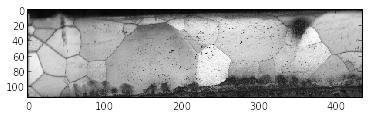

In [4]:
# read the merged ebsd scan data
import h5py
f = h5py.File('EBSD_beforeDef.h5')
nrows = f['EBSD_beforeDef/EBSD/Header/nRows'][0]
ncols = f['EBSD_beforeDef/EBSD/Header/nColumns'][0]
scan_step = f['EBSD_beforeDef/EBSD/Header/Step X'][0]
iq = np.reshape(f['EBSD_beforeDef/EBSD/Data/IQ'], (nrows, ncols)).T  # [x, y] form with x being the horizontal coordinate
f.close()
print(iq.shape)

plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray)

(741.09699999999998, 37.128999999999998)


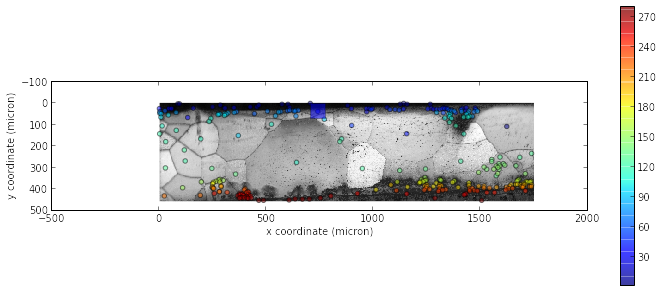

In [22]:
plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))
plt.scatter(grains[:, 4], grains[:, 5], c=grain_fakeids[:], alpha=0.5)
plt.plot(grains[34, 4], grains[34, 5], 's', markersize=15, alpha=0.5)
plt.colorbar()
plt.xlabel('x coordinate (micron)')
plt.ylabel('y coordinate (micron)')
# look at grain number 35
print(grains[34, 4], grains[34, 5])

In [23]:
# transformation matrix from A1A2A3 to XYZ
T = np.array([[ 0., 0., -1.],
              [-1., 0.,  0.],
              [ 0., 1.,  0.]])

from pymicro.crystal.microstructure import Microstructure, Grain, Orientation

micro = Microstructure()
for i in [34]: #range(len(grains)):
    o_tsl = Orientation.from_euler(grains[i, 1:4])
    g_xyz = np.dot(o_tsl.orientation_matrix(), T.T)  # move to XYZ local frame
    o_xyz = Orientation(g_xyz)
    g = Grain(grain_fakeids[i], o_xyz)
    g.position = np.array([grains[i, 4], grains[i, 5], 0.])
    micro.grains.append(g)

In [28]:
# compute misorientation between EBSD and DCT
o_dct = Orientation.from_rodrigues([0.797187, -0.534234, 0.116185])
print(o_dct)
(a, b, c) = o_dct.disorientation(micro.grains[0].orientation, crystal_structure='hexagonal')

Crystal Orientation
orientation matrix = [[ 0.69096044 -0.32020003  0.64810926]
 [-0.56044875  0.3289888   0.76004182]
 [-0.45658611 -0.88839085  0.04786254]]
Euler angles (degrees) = ( 332.799,  87.257,  40.455)
Rodrigues vector = [ 0.797187 -0.534234  0.116185]


ValueError: warning, crystal structure not supported: hexagonal

In [24]:
micro.grains

[Grain
  * id = 35
  * Crystal Orientation
 orientation matrix = [[ 0.14562703  0.04650164  0.98824611]
  [-0.90816494 -0.38997279  0.1521764 ]
  [ 0.39246554 -0.91965147 -0.01455942]]
 Euler angles (degrees) = (  23.111,  90.834,  81.246)
 Rodrigues vector = [ 1.4462763  -0.80391948  1.28818413]
  * position [ 741.097   37.129    0.   ]
  * has vtk mesh ? False]

Crystal Orientation
orientation matrix = [[ 0.14562703  0.04650164  0.98824611]
 [-0.90816494 -0.38997279  0.1521764 ]
 [ 0.39246554 -0.91965147 -0.01455942]]
Euler angles (degrees) = (  23.111,  90.834,  81.246)
Rodrigues vector = [ 1.4462763  -0.80391948  1.28818413]


[0, 1589, 534, 0]

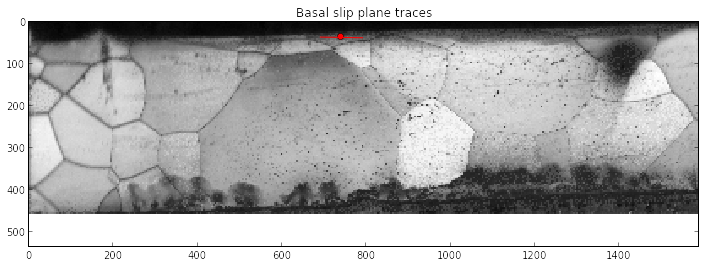

In [25]:
from pymicro.crystal.lattice import Lattice, HklPlane, HklDirection

trace_size = 100  # micron
Ti7Al = Lattice.hexagonal(0.2931, 0.4694)  # nm
p_basal = HklPlane(0, 0, 1, Ti7Al)  # basal plane
n_int = np.array([1, 0, 0])  # since X is going through the sample
view_up = np.array([0, 1, 0])  # here we want a figure with the sample horizontal as in the EBSD

#n_int = np.array([0, 0, -1])  # for orientation data in A1A2A3 (TSL)
#view_up = np.array([1, 0, 0])  # for orientation data in A1A2A3 (TSL)

plt.figure(figsize=(12, 5))
plt.imshow(iq.T, origin='upper', interpolation='nearest', cmap=cm.gray,
           extent=(0, scan_step * iq.shape[0], scan_step * iq.shape[1], 0))

for g in micro.grains:
    trace = p_basal.slip_trace(g.orientation, n_int, view_up, trace_size=100, verbose=False)
    if g.id == 35:
        color = 'r'
        print(g.orientation)
    else:
        color = 'b'
    x = g.position[0] + np.array([-trace[0] / 2, trace[0] / 2])
    y = g.position[1] + np.array([-trace[1] / 2, trace[1] / 2])
    plt.plot(g.position[0], g.position[1], 'o', color=color)
    plt.plot(x, y, 'b-', linewidth=1, color=color)
plt.title('Basal slip plane traces')
plt.axis([0, 1589, 534, 0])